<a href="https://colab.research.google.com/github/MohammadEshtehardian/Digital-Communication-Lab/blob/master/DigLabPro2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<center>
<div style="text-align: center;">
    <h1>Digital Communication Lab</h1>
    <h2>Programming Assignment 2</h2>
    <p><i>Seyed Mohammad Eshtehardian</i></p>
    <p><i>Amirmehdi Jafari Fesharki</i></p>
</div>
</center>

# Part 1. Symbol Rate

### QPSK

In **QPSK**, we should send all the data, which is equivalent to $2000$ bits or $1000$ symbols, and a pilot signal, which should be send in $0.1$ seconds, within $2$ seconds. So the symbol rate is:

$$
r_{s_{\text{QPSK}}} = \dfrac{1000}{1.9} \approx 526 \dfrac{\text{symbols}}{\text{second}}
$$

### DQPSK

In **DQPSK** we don't have to send pilot signal, but we should add a `00` symbol at the begining of the signal to find the other phases, so the symbol rate can be calculated as below:

$$
r_{s_{\text{DQPSK}}} = \dfrac{1001}{2} = 500.5 \dfrac{\text{symbols}}{\text{second}}
$$


# Part 2. Pilot Signal

If the time of pilot signal was too small, then the effect of noise was too large and we couldn't estimate $\Theta$ well. Also if the time was too long, then the symbol rate was too large and the error probability becamed very large.

# Part 3. Error Probability

Because in **DQPSK** two back to back symbols to find the phase, error in this modulation must be $3-dB$ poorer than **QPSK**. Also in **DQPSK** we have error propagation because calculating the phase of each symbol is correlated with the previous symbol.

# Part 4. Simulation

Fisrt we import libraries in the next cell:

In [1]:
# importing libraries
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import rayleigh
from scipy.fftpack import fft, ifft

First, I want to add effect of channel to the input modulated signal. In **Rayleigh** distribution we know that:

$$
  f(\alpha) = \dfrac{\alpha}{\sigma^2} e^{-\alpha^2/2\sigma^2}, \quad \alpha \ge 0\\
  E(\alpha) = \sigma \sqrt{\dfrac{\pi}{2}}\\
  Var(\alpha) = (2-\dfrac{\pi}{2})\sigma^2
$$

So we can write 

$$
E(\alpha^2) = 2\sigma^2 \implies \sigma = \sqrt{\dfrac{E(\alpha^2)}{2}}
$$

As the question said we have $E(\alpha^2)=0.8$ and so we should use $\sigma=\sqrt{0.4}$.

In [2]:
# channel effect
def channel(signal, sigma, snr=15, has_noise=True):
  # findning noise power
  signal_power = np.sum(signal ** 2) / len(signal)
  noise_power = signal_power / (10 ** (snr / 10))
  # changing phase of the signal
  theta = np.random.randint(0, 360)/360*2*np.pi
  freq_signal = fft(signal)
  freq_signal_phase_shifted = np.abs(freq_signal)*np.exp(1j*(np.angle(freq_signal)+theta))
  signal = np.real(ifft(freq_signal_phase_shifted))
  # changing amplitude of the signal
  rayleigh_dist = rayleigh(scale=sigma)
  attenuation = rayleigh_dist.rvs(size=1)
  signal *= attenuation
  # adding noise to the signal
  noise = np.random.normal(scale=np.sqrt(noise_power), size=len(signal))
  if has_noise:
    signal += noise
  return signal

Now we want to write **DQPSK** modulator and demodulator in the next cells. As we already now, **DQPSK** change the phase of the signal on the basis of the changes of the symbols. For example, if symbols change from `00` to `01`, then we should change the carrier phase $\frac{\pi}{4}$.

In [3]:
# DQPSK modulation
def dqpsk_modulator(data, interval, fc, fs):
  # time for each symbol
  t = interval / (len(data)/2 + 1)
  # defining constellation
  constellation = {
    "00": np.pi/4,
    "01": 3*np.pi/4,
    "11": -3*np.pi/4,
    "10": -np.pi/4
  }
  # creating a list of symbols
  symbols = ["00"]
  for i in range(0, len(data), 2):
      symbol = data[i:i+2]
      symbols.append(symbol)
  # first symbol with known phase
  previous_symbol = "00"
  previous_phase = 0
  # find the symbols
  modulated_signal = np.zeros((int(interval*fs),))
  n = int(round(t*fs)) # number of samples for each symbol
  for ind, symbol in enumerate(symbols):
    if ind == 0:
      phase = 0
    else:
      delta_phase = constellation[symbol] - constellation[previous_symbol]
      phase = previous_phase + delta_phase
    sample_times = np.linspace(ind*t, (ind+1)*t-1/fs, n)
    modulated_signal[ind*n:(ind+1)*n] = np.cos(2*np.pi*fc*sample_times+phase)
    previous_symbol = symbol
    previous_phase = phase
  return modulated_signal

In [4]:
# DQPSK demodulation
def dqpsk_demodulator(modulated_signal, interval, fc, fs, rs):
  # defining constellation
  constellation = {
    "00": np.pi/4,
    "01": 3*np.pi/4,
    "11": -3*np.pi/4,
    "10": -np.pi/4
  }
  # creating a list of symbols
  symbol_num = int(rs*interval)
  symbols = ''
  # time for each symbol
  t = interval / symbol_num
  n = int(round(t*fs)) # number of samples for each symbol
  previous_phase = 0
  previous_symbol = '00'
  for ind in range(symbol_num):
    # finding the phase of the signal associated with each symbol
    signal = modulated_signal[ind*n:(ind+1)*n]
    sample_times = np.linspace(ind*t, (ind+1)*t-1/fs, n)
    pure_cosine = np.cos(2*np.pi*fc*sample_times)
    pure_sine = np.sin(2*np.pi*fc*sample_times)
    cosine_dot = np.dot(signal, pure_cosine)
    sine_dot = np.dot(signal, pure_sine)
    phase = np.arctan2(-sine_dot, cosine_dot)
    if phase < 3*np.pi/4 and phase >= np.pi/4:
      phase = np.pi/2
    elif phase < np.pi/4 and phase >= -np.pi/4:
      phase = 0
    elif phase < -np.pi/4 and phase >= -3*np.pi/4:
      phase = -np.pi/2
    else:
      phase = -np.pi
    delta_phase = phase - previous_phase
    if ind == 0:
      symbol = "00"
    else:
      symbol_constellation = delta_phase + constellation[previous_symbol]
      symbol_constellation = np.arctan2(np.sin(symbol_constellation), np.cos(symbol_constellation))
      symbol = [symbol for symbol, ph in constellation.items() if abs(ph-symbol_constellation)<1e-3][0]
    previous_phase = phase
    previous_symbol = symbol
    symbols += str(symbol)
  return symbols[2:]

In this part we will simpulate our **DQPSK** functions to find the error rate.

In [8]:
def dqpsk_simulator(t, n, t0, sigma, snr, fc, fs):
  '''
  t: time of simulation
  n: number of bits in each slot
  t0: time of each slot
  sigma: rayleigh distribution parameter
  snr: snr at the reciever in dB
  fc: carrier frequency
  fs: sampling frequency
  '''
  m = int(t / t0) # number of slots
  N = n * m # total number of bits
  data = ''.join([np.random.choice(['0', '1']) for _ in range(N)]) # random data
  errors_cnt = 0 # number of errors
  r_s = (n//2+1) / t0
  for i in range(m):
    slot_data = data[n*i: n*(i+1)]
    transmitted_signal = dqpsk_modulator(slot_data, t0, fc, fs)
    recieved_signal = channel(transmitted_signal, sigma, snr)
    demod_signal = dqpsk_demodulator(recieved_signal, t0, fc, fs, r_s)
    slot_data_array = np.fromiter(slot_data, dtype=np.int8)
    demod_signal_array = np.fromiter(demod_signal, dtype=np.int8)
    errors_cnt += np.count_nonzero(slot_data_array - demod_signal_array)
  print("Error probability in DQPSK is {:.3f}%.".format(errors_cnt/N*100))

In [11]:
dqpsk_simulator(10000, 2000, 2, np.sqrt(0.4), 15, 500.5*8, 500.5*20)

Error probability in DQPSK is 4.061%.


Now we want to simulate **QPSK** modulation. In the next cells, we will write functions for the modulator and demodulator and then we'll find the bit error probability.

In [55]:
# QPSK modulation
def qpsk_modulator(data, interval, pilot_time, fc, fs):
  # time for each symbol
  t = interval * (1-pilot_time) / (len(data)/2)
  # number of additional symbols
  add_sym_num = int(pilot_time * interval / t)
  # defining constellation
  constellation = {
    "00": 0,
    "01": np.pi/2,
    "11": np.pi,
    "10": -np.pi/2
  }
  # creating a list of symbols
  symbols = []
  for i in range(add_sym_num):
    symbols.append("00")
  for i in range(0, len(data), 2):
      symbol = data[i:i+2]
      symbols.append(symbol)
  # find the symbols
  modulated_signal = np.zeros((int(interval*fs),))
  n = int(round(t*fs)) # number of samples for each symbol
  for ind, symbol in enumerate(symbols):
    phase = constellation[symbol]
    sample_times = np.linspace(ind*t, (ind+1)*t-1/fs, n)
    modulated_signal[ind*n:(ind+1)*n] = np.cos(2*np.pi*fc*sample_times+phase)
  return modulated_signal

In [91]:
# QPSK demodulation
def qpsk_demodulator(modulated_signal, interval, pilot_time, fc, fs, rs):
  # defining constellation
  constellation = {
    "00": 0,
    "01": np.pi/2,
    "11": np.pi,
    "10": -np.pi/2
  }
  # creating a list of symbols
  symbol_num = int(rs*interval)
  symbols = ''
  # time for each symbol
  t = interval / symbol_num
  # number of additional symbols
  add_sym_num = int(pilot_time * interval / t)
  n = int(round(t*fs)) # number of samples for each symbol
  # finding the phase of the channel
  period_num = int(t*add_sym_num*fc)
  add_sym_time = period_num * 1/fc # time of pilot signal with full period
  m = int(round(add_sym_time*fs)) # number of samples with full period
  pilot_signal = modulated_signal[0:m]
  sample_times = np.linspace(0, add_sym_time-1/fs, m)
  pure_cosine = np.cos(2*np.pi*fc*sample_times)
  pure_sine = np.sin(2*np.pi*fc*sample_times)
  cosine_dot = np.dot(pilot_signal, pure_cosine)
  sine_dot = np.dot(pilot_signal, pure_sine)
  channel_phase = np.arctan2(-sine_dot, cosine_dot)
  for i in range(symbol_num - add_sym_num):
    # finding the phase of the signal associated with each symbol
    ind = i + add_sym_num
    signal = modulated_signal[ind*n:(ind+1)*n]
    dft = np.fft.fft(signal)
    cos_idx = int(np.round(fc/fs*len(signal)))
    phase = np.angle(dft[cos_idx])
    phase -= channel_phase
    if phase < 3*np.pi/4 and phase >= np.pi/4:
      phase = np.pi/2
    elif phase < np.pi/4 and phase >= -np.pi/4:
      phase = 0
    elif phase < -np.pi/4 and phase >= -3*np.pi/4:
      phase = -np.pi/2
    else:
      phase = np.pi
    symbol = [symbol for symbol, ph in constellation.items() if abs(ph-phase)<1e-3][0]
    symbols += str(symbol)
  return symbols

In [100]:
def qpsk_simulator(t, n, t0, sigma, pilot_time, snr, fc, fs, rs):
  '''
  t: time of simulation
  n: number of bits in each slot
  t0: time of each slot
  sigma: rayleigh distribution parameter
  snr: snr at the reciever in dB
  fc: carrier frequency
  fs: sampling frequency
  rs: symbol rate
  '''
  m = int(t / t0) # number of slots
  N = n * m # total number of bits
  data = ''.join([np.random.choice(['0', '1']) for _ in range(N)]) # random data
  errors_cnt = 0 # number of errors
  for i in range(m):
    slot_data = data[n*i: n*(i+1)]
    transmitted_signal = qpsk_modulator(slot_data, t0, pilot_time, fc, fs)
    recieved_signal = channel(transmitted_signal, sigma, snr)
    demod_signal = qpsk_demodulator(recieved_signal, t0, pilot_time, fc, fs, rs)
    slot_data_array = np.fromiter(slot_data, dtype=np.int8)
    demod_signal_array = np.fromiter(demod_signal, dtype=np.int8)
    errors_cnt += np.count_nonzero(slot_data_array - demod_signal_array)
  print("Error probability in QPSK is {:.3f}%.".format(errors_cnt/N*100))

In [102]:
t0 = 2
rs = 1000 / 1.9
fc = rs * 8
fs = rs * 190
pilot_time = 0.05
qpsk_simulator(100, 2000, t0, np.sqrt(0.4), 0.05, 15, fc, fs, rs)

Error probability in QPSK is 13.875%.


# Part 5. Plots

In this part we will plot the transmitted and recived signal. First we will plot for **DQPSK** modulation.

In [ ]:
def dqpsk_plot(n, t0, sigma, fc, fs, symbol_num, xticks=[]):
  m = int(round(fs*t0/(n//2+1)))
  data = ''.join([np.random.choice(['0', '1']) for _ in range(n)])
  transmitted_signal = dqpsk_modulator(data, t0, fc, fs)
  recieved_signal = channel(transmitted_signal, sigma, has_noise=False)
  times = np.linspace(0, (symbol_num*m-1)/fs, symbol_num*m)
  fig, ax = plt.subplots(2, sharex=True)
  fig.suptitle('DQPSK Modulation Signals')
  ax[0].plot(times, transmitted_signal[0:symbol_num*m], color='blue')
  ax[0].set_title('Modulated Signal')
  ax[0].set_ylabel('x(t)')
  ax[0].grid()
  ax[1].plot(times, recieved_signal[0:symbol_num*m], color='green')
  ax[1].set_title('Recieved Signal')
  ax[1].set_ylabel('y(t)')
  ax[1].grid()
  plt.xlabel('Time')
  plt.xticks(xticks)
  plt.show()

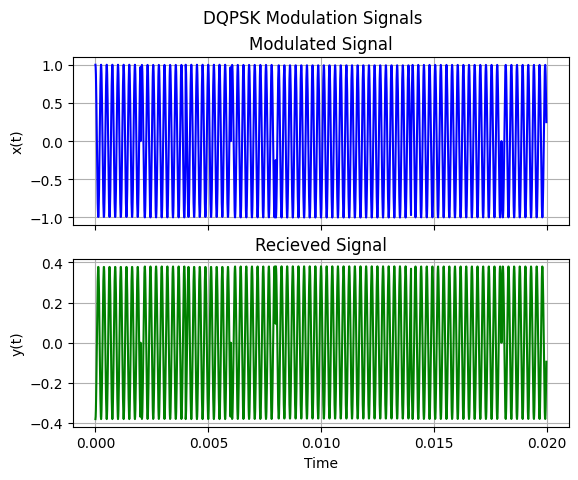

In [ ]:
dqpsk_plot(2000, 2, np.sqrt(0.4), 500.5*8, 500.5*200, 10, np.linspace(0, 0.02, 5))

Now we write function for **QPSK**:

In [125]:
def qpsk_plot(n, t0, sigma, pilot_time, fc, fs, start, symbol_num, xticks=[]):
  data = ''.join([np.random.choice(['0', '1']) for _ in range(n)])
  t = t0 * (1-pilot_time) / (n/2)
  m = int(fs*t)
  transmitted_signal = qpsk_modulator(data, t0, pilot_time, fc, fs)
  recieved_signal = channel(transmitted_signal, sigma, has_noise=False)
  times = np.linspace(start*t, ((symbol_num+start)*m-1)/fs, symbol_num*m)
  if xticks == []:
    xticks = np.linspace(start*t, ((symbol_num+start)*m-1)/fs, 5)
  fig, ax = plt.subplots(2, sharex=True)
  fig.suptitle('QPSK Modulation Signals')
  ax[0].plot(times, transmitted_signal[start*m:(symbol_num+start)*m], color='blue')
  ax[0].set_title('Modulated Signal')
  ax[0].set_ylabel('x(t)')
  ax[0].grid()
  ax[1].plot(times, recieved_signal[start*m:(symbol_num+start)*m], color='green')
  ax[1].set_title('Recieved Signal')
  ax[1].set_ylabel('y(t)')
  ax[1].grid()
  plt.xlabel('Time')
  plt.xticks(xticks)
  plt.show()

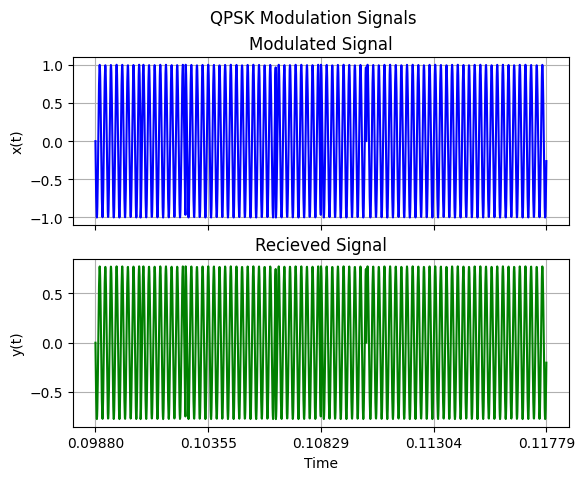

In [126]:
rs = 1000 / 1.9
fc = rs * 8
fs = rs * 190
qpsk_plot(2000, 2, np.sqrt(0.4), 0.05, fc, fs, 52, 10)